In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:

# Generate physically meaningful 2D data: spring oscillator state (x, v)
def generate_data(num_classes=10, num_samples=200, scale=4):
    # Randomly generate initial position and velocity
    # Set random seed for reproducible results
    np.random.seed(42)

    # Number of data points (each point corresponds to a small Gaussian distribution)

    # Randomly generate encoder output mean mu and variance sigma (2D)
    mus = (np.random.rand(num_classes, 2)-0.5 )* scale

    # Generate each small Gaussian distribution (approximated by sampling points)
    data_list = []
    for i in range(num_classes):
        mu = mus[i]
        
        # Sample from small Gaussian distribution
        samples = (np.random.rand(num_samples, 2)-0.5) + mu
        data_list.append(samples)

    return data_list, mus

Text(0.5, 1.0, 'Original data')

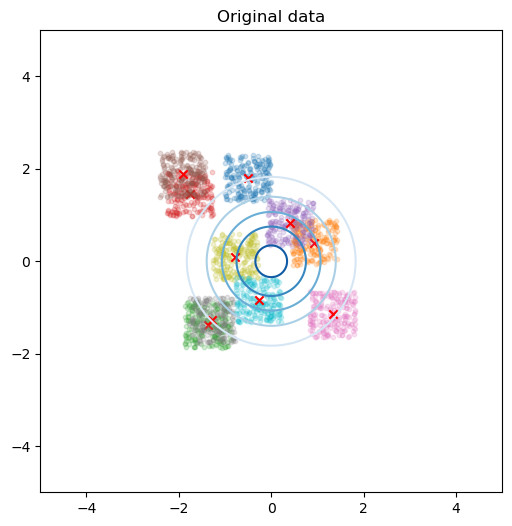

In [3]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))

data_list, mus = generate_data()
# 绘制大球（标准正态分布的等高线）

for data, mu in zip(data_list, mus):
    ax.scatter(data[:, 0], data[:, 1], alpha=0.2, s=10)
    ax.scatter(mu[0], mu[1], c="red", marker="x")
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.5 * (X**2 + Y**2)) / (2 * np.pi)
ax.contour(X, Y, Z, levels=5, cmap="Blues")

ax.set_aspect("equal")
ax.set_title("Original data")

# plt.show()

In [4]:

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden_dim=32):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

# Loss function
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld


In [5]:
# Generate data
data = np.concatenate(data_list)
x_train = torch.from_numpy(data).to(torch.float32)

# Train VAE
vae = VAE(input_dim=2, latent_dim=2, hidden_dim=32)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
vae.train()
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    x_recon, mu, logvar, z = vae(x_train)
    loss = vae_loss(x_train, x_recon, mu, logvar)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 200, Loss: 1.0046
Epoch 400, Loss: 0.9745
Epoch 600, Loss: 0.9500
Epoch 800, Loss: 0.9584
Epoch 1000, Loss: 0.9372
Epoch 1200, Loss: 0.9275
Epoch 1400, Loss: 0.9266
Epoch 1600, Loss: 0.9289
Epoch 1800, Loss: 0.9105
Epoch 2000, Loss: 0.9074
Epoch 2200, Loss: 0.9270
Epoch 2400, Loss: 0.9332
Epoch 2600, Loss: 0.9270
Epoch 2800, Loss: 0.9202
Epoch 3000, Loss: 0.9148
Epoch 3200, Loss: 0.9270
Epoch 3400, Loss: 0.9268
Epoch 3600, Loss: 0.9178
Epoch 3800, Loss: 0.9477
Epoch 4000, Loss: 0.9408
Epoch 4200, Loss: 0.9214
Epoch 4400, Loss: 0.9030
Epoch 4600, Loss: 0.9194
Epoch 4800, Loss: 0.9191
Epoch 5000, Loss: 0.9239
Epoch 5200, Loss: 0.9095
Epoch 5400, Loss: 0.9203
Epoch 5600, Loss: 0.9218
Epoch 5800, Loss: 0.9254
Epoch 6000, Loss: 0.9344
Epoch 6200, Loss: 0.9228
Epoch 6400, Loss: 0.9226
Epoch 6600, Loss: 0.9166
Epoch 6800, Loss: 0.9252
Epoch 7000, Loss: 0.9307
Epoch 7200, Loss: 0.9116
Epoch 7400, Loss: 0.9183
Epoch 7600, Loss: 0.9198
Epoch 7800, Loss: 0.9214
Epoch 8000, Loss: 0.9330
Epoc

Text(0.5, 1.0, 'VAE latent space')

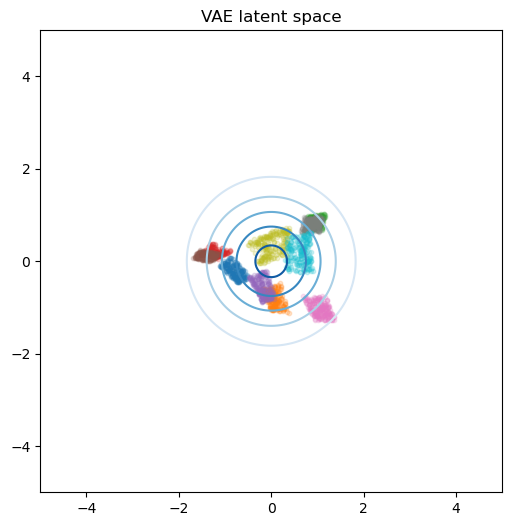

In [6]:
# Visualize original data and latent space using seaborn jointplot
vae.eval()
with torch.no_grad():
    _, mu, _, z = vae(x_train)
    z = z.numpy()
    x_np = x_train.numpy()

z = z.reshape(len(data_list), -1, 2)
mu = mu.reshape(len(data_list), -1, 2)

fig, ax = plt.subplots(1,1,figsize=(6, 6))

for i in range(len(data_list)):
    ax.scatter(mu[i, :, 0], mu[i, :, 1], alpha=0.2, s=10)

x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.5 * (X**2 + Y**2)) / (2 * np.pi)
ax.contour(X, Y, Z, levels=5, cmap="Blues")

ax.set_aspect("equal")
ax.set_title("VAE latent space")


